In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Carico il dataset
df = pd.read_csv('CarPrice_Assignment.csv')
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [4]:
#Noto che il numero delle porte può essere trasformato in numero

#Tutto in Minuscolo
df['doornumber'] = df['doornumber'].str.lower()
#Mapping Errato -> corretto
map = {
    'two':       2,
    'four':    4,
    }

# Applica la sostituzione
df['doornumber'] = df['doornumber'].replace(map)

C:\Users\anto-\AppData\Local\Temp\ipykernel_13832\4030365291.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['doornumber'] = df['doornumber'].replace(map)


In [5]:
#Splitto la colonna di CarName poiché noto che è composta da "Marca Nome_Auto" in place
df['CarName'] = df['CarName'].str.split(' ', expand=True)[0]
#printo tutti gli elementi di CarName in una lista
print(df['CarName'].unique())

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']


In [6]:
#Conto quante marche sono presenti
df['CarName'].nunique()

28

In [7]:
#Noto che alcune marche assomigliano ad altre con errori di battitura li ritrasformo

#Tutto in Minuscolo
df['CarName'] = df['CarName'].str.lower()
#Mapping Errato -> corretto
brand_map = {
    'maxda':       'mazda',
    'porcshce':    'porsche',
    'vokswagen':   'volkswagen',
    'vw':          'volkswagen',
    'toyouta':     'toyota',
    'nissan':      'nissan',
    'alfa-romero': 'alfa-romeo'   #alfa romorero sbagliato in alfa romeo corretto
}

# Applica la sostituzione
df['CarName'] = df['CarName'].replace(brand_map)

In [8]:
#Conto quante marche sono presenti dopo il mapping
print(df['CarName'].nunique())
print(df['CarName'].unique())

22
['alfa-romeo' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


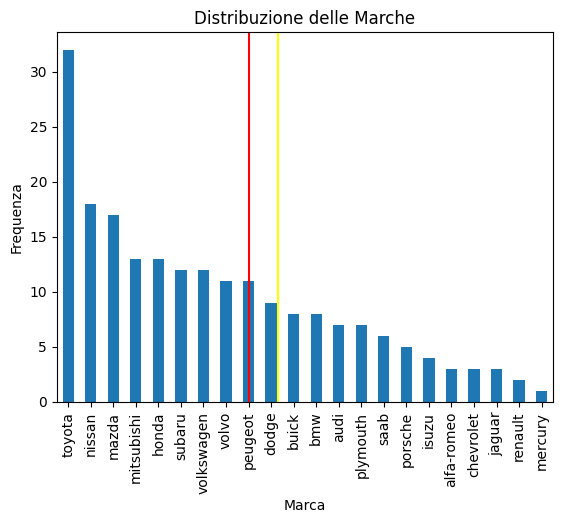

In [9]:
#Distribuzione delle marche con linea di demarcazione della mediana
df['CarName'].value_counts().plot(kind='bar')
plt.title('Distribuzione delle Marche')
plt.xlabel('Marca')
plt.ylabel('Frequenza')
plt.axvline(df['CarName'].value_counts().mean(), color='yellow')
plt.axvline(df['CarName'].value_counts().median(), color='red')
plt.show()

In [10]:
# Visualizzando i dati mi sono accorto che alcune marche hanno pochi campioni, quindi li ragruppo in una categoria "Other"
# Il Criterio di ragruppamento sarà quello di ragruppare tutte le categorie con frequenza sotto la mediana
threshold = df['CarName'].value_counts().median()
df['CarName'] = df['CarName'].apply(lambda x: 'Other' if df['CarName'].value_counts()[x] < threshold else x)
print(df['CarName'].unique())

['Other' 'bmw' 'dodge' 'honda' 'mazda' 'buick' 'mitsubishi' 'nissan'
 'peugeot' 'subaru' 'toyota' 'volkswagen' 'volvo']


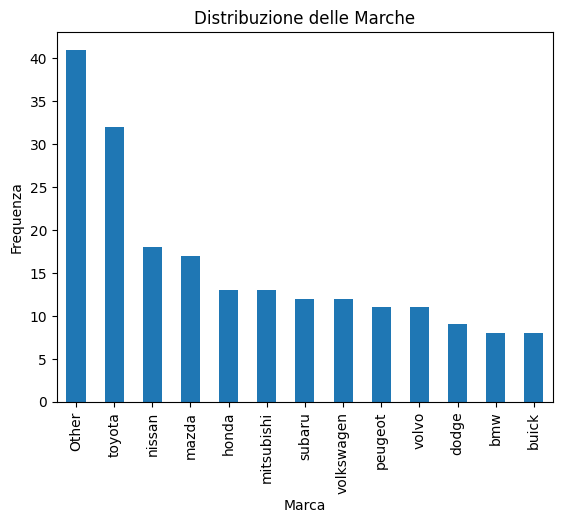

In [11]:
#Distribuzione delle marche con linea di demarcazione della mediana
df['CarName'].value_counts().plot(kind='bar')
plt.title('Distribuzione delle Marche')
plt.xlabel('Marca')
plt.ylabel('Frequenza')
plt.show()

In [12]:
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,Other,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,Other,gas,std,2,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,Other,gas,std,2,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,Other,gas,std,4,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,Other,gas,std,4,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [13]:
df.drop(['car_ID'], axis=1, inplace=True)
X ,y = df.drop('price', axis=1), df['price']

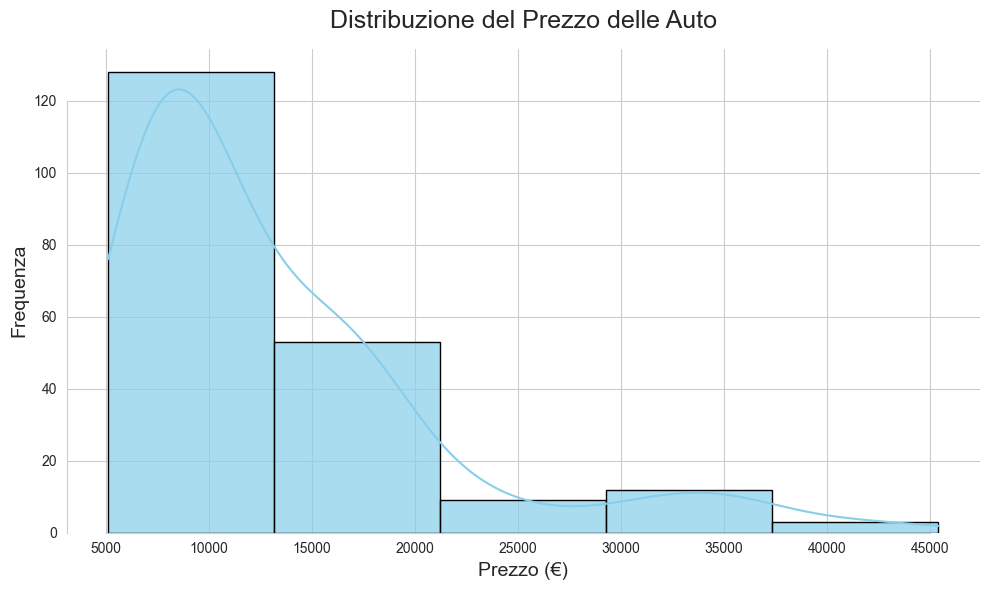

In [14]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Istogramma
sns.histplot(
    df['price'],
    bins=5,
    kde=True,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

plt.title('Distribuzione del Prezzo delle Auto', fontsize=18, pad=15)
plt.xlabel('Prezzo (€)', fontsize=14)
plt.ylabel('Frequenza', fontsize=14)

# Rimuove i bordi superiori e destri
sns.despine(trim=True)

plt.tight_layout()
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Codifico le variabili categoriche
X_train[['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem','CarName']] = ord_enc.fit_transform(X_train[['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem','CarName']])
X_test[['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem','CarName']] = ord_enc.transform(X_test[['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem','CarName']])
X_train.head()
# Standardizzo le feature numeriche
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

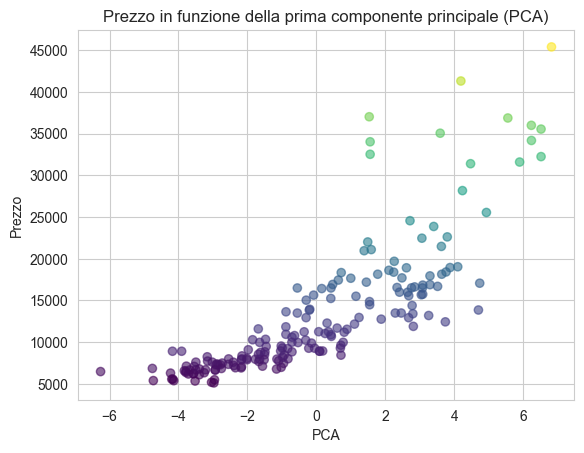

In [17]:
#PCA dei dati per visualizzarli in 2D
pca_prezzo = PCA(n_components=1)
X_pca_prezzo = pca_prezzo.fit_transform(X_train)
#visualizzo la funzione del prezzo in funzione della PCA
plt.scatter(X_pca_prezzo, y_train,c=y_train, cmap='viridis', alpha=0.6)
plt.title('Prezzo in funzione della prima componente principale (PCA)')
plt.xlabel('PCA')
plt.ylabel('Prezzo')
plt.show()

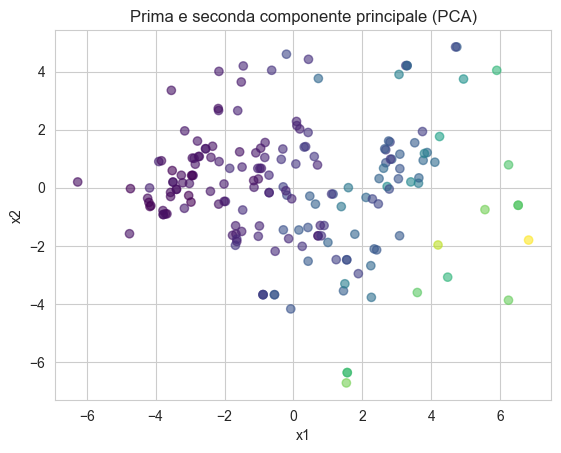

In [18]:
#PCA dei dati per visualizzarli in 2D
pca_features = PCA(n_components=2)
X_pca_features = pca_features.fit_transform(X_train)
#visualizzo la funzione del prezzo in funzione della PCA
plt.scatter(X_pca_features[:,0], X_pca_features[:,1], c=y_train, cmap='viridis', alpha=0.6)
plt.title('Prima e seconda componente principale (PCA)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [19]:
# Definisco i parametri da testare per RandomForest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definisco i parametri da testare per Ridge
ridge_params = {
    'kernel': ['linear', 'polynomial'],
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
    'degree': [2, 3, 4]  # Solo per kernel='polynomial'
}

# GridSearch per RandomForest
print("Eseguendo GridSearch per RandomForest...")
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,verbose=2
)
rf_grid.fit(X_train, y_train)

# GridSearch per Ridge
print("Eseguendo GridSearch per Ridge...")
ridge_grid = GridSearchCV(
    KernelRidge(),
    ridge_params,
    cv=5,
    scoring='r2',
    n_jobs=-1,verbose=2
)
ridge_grid.fit(X_train, y_train)

# Risultati migliori parametri
print(f"\nMigliori parametri RandomForest: {rf_grid.best_params_}")
print(f"Migliori parametri Ridge: {ridge_grid.best_params_}")

# Predizioni con i migliori modelli
rf_best = rf_grid.best_estimator_
ridge_best = ridge_grid.best_estimator_

rf_pred = rf_best.predict(X_test)
ridge_pred = ridge_best.predict(X_test)

# Metriche di valutazione
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.2f}")

# Valutazione dei modelli
evaluate_model(y_test, rf_pred, "RandomForest (Best)")
evaluate_model(y_test, ridge_pred, "Ridge (Best)")



Eseguendo GridSearch per RandomForest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Eseguendo GridSearch per Ridge...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Migliori parametri RandomForest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Migliori parametri Ridge: {'alpha': 1.0, 'degree': 2, 'kernel': 'polynomial'}

RandomForest (Best):
R² Score: 0.9388
MSE: 4900048.68

Ridge (Best):
R² Score: 0.9578
MSE: 3379439.76



RandomForest (Best) con PCA - Test:
R² Score: 0.8599
MSE: 11222331.81

Ridge (Best) con PCA - Test:
R² Score: 0.9459
MSE: 4336082.00


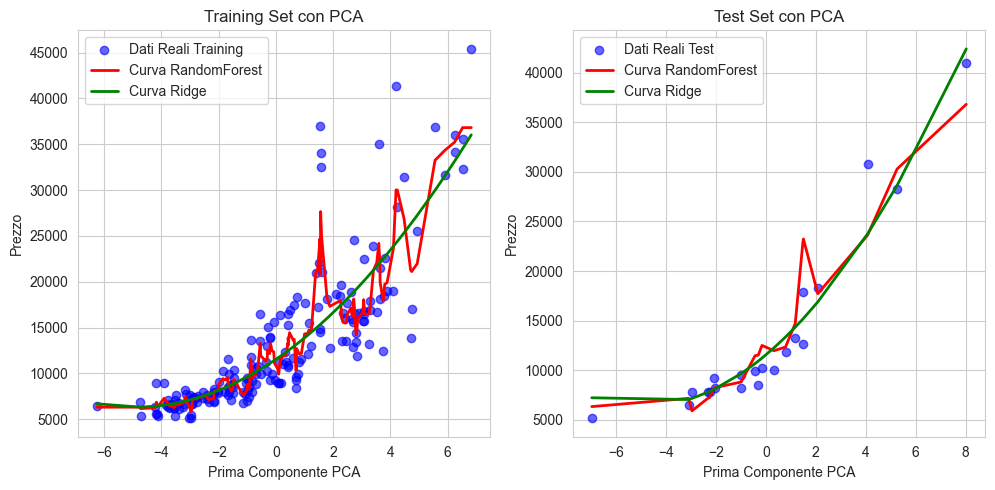

In [20]:
# Riaddestro i modelli con i migliori parametri sui dati con la PCA ad 1 dimensione
rf_best_pca = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_best_pca.fit(X_pca_prezzo, y_train)
ridge_best_pca = KernelRidge(**ridge_grid.best_params_)
ridge_best_pca.fit(X_pca_prezzo, y_train)

# CORREZIONE: Usa X_test_scaled invece di X_test
X_test_pca = pca_prezzo.transform(X_test)

# Predizioni sui dati di test con PCA
rf_pred_test_pca = rf_best_pca.predict(X_test_pca)
ridge_pred_test_pca = ridge_best_pca.predict(X_test_pca)

# Valutazione dei modelli sui dati di test
evaluate_model(y_test, rf_pred_test_pca, "RandomForest (Best) con PCA - Test")
evaluate_model(y_test, ridge_pred_test_pca, "Ridge (Best) con PCA - Test")

# Visualizzazione dei risultati con curve di predizione
plt.figure(figsize=(15, 5))

# Plot 1: Dati di training
plt.subplot(1, 3, 1)
plt.scatter(X_pca_prezzo, y_train, color='blue', label='Dati Reali Training', alpha=0.6)
# Crea una curva smooth per le predizioni
X_sorted_idx = np.argsort(X_pca_prezzo.flatten())
rf_pred_train = rf_best_pca.predict(X_pca_prezzo)
ridge_pred_train = ridge_best_pca.predict(X_pca_prezzo)
plt.plot(X_pca_prezzo[X_sorted_idx], rf_pred_train[X_sorted_idx],
         color='red', label='Curva RandomForest', linewidth=2)
plt.plot(X_pca_prezzo[X_sorted_idx], ridge_pred_train[X_sorted_idx],
         color='green', label='Curva Ridge', linewidth=2)
plt.title('Training Set con PCA')
plt.xlabel('Prima Componente PCA')
plt.ylabel('Prezzo')
plt.legend()

# Plot 2: Dati di test
plt.subplot(1, 3, 2)
plt.scatter(X_test_pca, y_test, color='blue', label='Dati Reali Test', alpha=0.6)
# Crea curve smooth per i dati di test
X_test_sorted_idx = np.argsort(X_test_pca.flatten())
plt.plot(X_test_pca[X_test_sorted_idx], rf_pred_test_pca[X_test_sorted_idx],
         color='red', label='Curva RandomForest', linewidth=2)
plt.plot(X_test_pca[X_test_sorted_idx], ridge_pred_test_pca[X_test_sorted_idx],
         color='green', label='Curva Ridge', linewidth=2)
plt.title('Test Set con PCA')
plt.xlabel('Prima Componente PCA')
plt.ylabel('Prezzo')
plt.legend()


plt.tight_layout()
plt.show()